In [1]:
from datetime import datetime
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cdsapi

ERA_VERSION = 'ERA5'

In [2]:
# ====================
# To get a CDS API key, sign up at https://cds.climate.copernicus.eu/
# It is free and easy! After registering, copy your "Personal Access Token here"
# ====================
KEY = '############################'
KEY = '6cc2b53b-e3c0-42fd-b7ad-db64aeeb5298'

# ====================
# Change these to plot different locations. You can see the currently used ones in the ERA Explorer URL
# ====================
lat = 50.86  # Default latitude
lng = 4.35  # Default longitude

In [ ]:
# Define the URL for the CDS API
URL = 'https://cads-mini-cci1.copernicus-climate.eu/api'

# Define the dataset and request parameters
dataset = "test-adaptor-arco"
request = {
    "variable": [
        "total_precipitation",  # Variable to retrieve
    ],
    "date": ["1940-01-01/2023-12-31"],  # Date range for the data
    "location": {"longitude": lng, "latitude": lat},  # Location coordinates
    "data_format": "netcdf"  # Format of the retrieved data
}

# Define the filename for the data download
timeseries_file = f"{dataset}_precipAnn.nc"

# Initialize the CDS API client with the URL and API key
client = cdsapi.Client(url=URL, key=KEY)

# Retrieve the data from the CDS API and save it to the specified file
client.retrieve(dataset, request, timeseries_file)

2024-11-27 17:45:10,073 CRITICAL [2024-11-27T00:00:00] System is currently unavailable. Please follow updates [here](https://forum.ecmwf.int/t/cds-ads-and-ewds-down-until-further-notice/8015) and status [here](https://status.ecmwf.int/)
2024-11-27 17:45:10,074 INFO [2024-09-28T00:00:00] **Welcome to the New Climate Data Store (CDS)!** This new system is in its early days of full operations and still undergoing enhancements and fine tuning. Some disruptions are to be expected. Your 
[feedback](https://jira.ecmwf.int/plugins/servlet/desk/portal/1/create/202) is key to improve the user experience on the new CDS for the benefit of everyone. Thank you.
2024-11-27 17:45:10,074 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2024-11-27 17:45:10,075 INFO [2024-09-16T00:00:00] Remember that you need to have an ECMWF account to use the new CDS. **Your old CDS credentials will not work in new CDS!**
2024-11-27 17:45:10,075

'test-adaptor-arco_tempAnn.nc'

In [4]:
# Make a function to compute the annual mean precipitation time series
def precipAnnualTimeseries(x, y):
    """
    Processes the annual precipitation timeseries for given coordinates.

    This function reads a NetCDF dataset containing precipitation data, removes the incomplete year,
    resamples the data to annual sums, and converts the values to millimeters.

    Parameters:
    x (float): The x-coordinate (longitude) of the location.
    y (float): The y-coordinate (latitude) of the location.

    Returns:
    tuple: A tuple containing two elements:
        - years (numpy.ndarray): An array of years corresponding to the annual precipitation sums.
        - values (numpy.ndarray): An array of annual precipitation sums in millimeters.
    """

    print("Processing precip annual timeseries for coordinates ({}, {})".format(x, y))

    data = xr.open_dataset(timeseries_file)
    data_tp_pt = data.tp

    # Remove incomplete year
    current_year = datetime.now().year
    timestamp_string = '{:d}-12-31 00:00:00'.format(current_year - 1)
    cutoff_date = pd.Timestamp(timestamp_string)
    data_tp_pt_trun = data_tp_pt.sel(valid_time=slice(None, cutoff_date))

    # Resample the data to annual sums and convert to mm
    data_tp_pt_agg = data_tp_pt_trun.resample(valid_time="YE").sum() * 1000
    years = data_tp_pt_agg.valid_time.to_index().year
    values = data_tp_pt_agg.values.flatten()

    return (years, values)

In [5]:
# Call our function
years1, ts1 = precipAnnualTimeseries(lng, lat)

Processing precip annual timeseries for coordinates (4.35, 50.86)


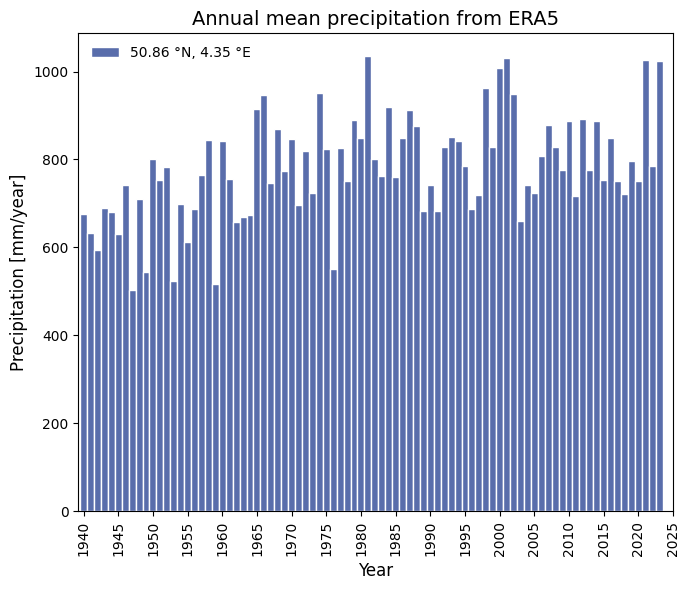

In [14]:
# Make the plot
lw = 2
marker = 'o'
markersize = 4

latSuffix = 'N' if lat > 0 else 'S'
lngSuffix = 'E' if lng > 0 else 'W'

# Create a new figure
plt.figure(figsize=(7, 6))

# Plot the data as a bar chart
plt.bar(
    years1,
    ts1,
    width=1,
    color='#596DAB',
    label=f'{abs(lat):.2f} °{latSuffix:s}, {abs(lng):.2f} °{lngSuffix:s}',
    edgecolor='white',
    clip_on=False
)
# Add legend
plt.legend(framealpha=0)

# Set x-ticks to appear every 10 years and rotate them
plt.xticks(np.arange(1940, 2026, 5), rotation=90)
plt.xlim(1940-0.75, 2025)

# Customize x and y axis labels
plt.xlabel('Year', fontsize=12)
plt.ylabel('Precipitation [mm/year]', fontsize=12)

# Add title with custom font
plt.title('Annual mean precipitation from {:s}'.format(ERA_VERSION), fontsize=14)

# Show the plot
plt.tight_layout()  # Adjust layout to prevent overlap
plt.show()